<a href="https://colab.research.google.com/github/BralexMtz/First-AI-Algorithms/blob/main/BuildingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt
#torch.set_printoptions(edgeitems=2) #default 3
#torch.manual_seed(123)

# Construyendo modelo
---



In [2]:
data_path = 'data/'
full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

full_validation_set = datasets.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [3]:
size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer
car
ship
horse


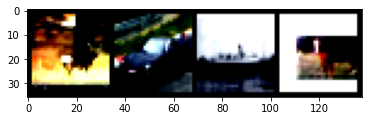

In [4]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(utils.make_grid(imgs).permute(1, 2, 0))

for i in range(size):
  print(classes[labels[i]])

In [5]:
#classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
class_names = ['car', 'cat']
# mapeamos unicamente los carros y gatos
label_map = {1: 0, 3: 1}
# hacemos nuevos arreglos para el data_set y validation set a partir del mapeo anterior
data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1, 3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1, 3]]

In [6]:
img, label = data_set[20]
img.shape

torch.Size([3, 32, 32])

In [7]:
model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512), # ( shape, num arbitrario de neuronas)
            nn.Tanh(), # funcion de activacion que puede ser otras opciones
            nn.Linear(512, 2)) # ( numero intermedio de nodos  ,2 es por la clasificacion binaria )

In [8]:
# como necesitamos probabilidad podemos usar
# sigmoide o softmax
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

In [9]:
x = torch.tensor([1.0, 2.0, 3.0])

sigmoid(x)

tensor([0.7311, 0.8808, 0.9526])

In [10]:
sigmoid(x).sum()

tensor(2.5644)

In [11]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [12]:
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [13]:
softmax(x).sum()

tensor(1.)

In [14]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [15]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)) # podemos usar softmax para obtener la probabilidad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'car'

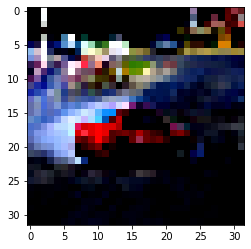

In [16]:
img, label = data_set[20]

plt.imshow(img.permute(1, 2, 0))
class_names[label] # mostramos la etiqueta e imagen

In [17]:
# tensor con probabilidad y la dimension extra
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.4725, 0.5275]], grad_fn=<SoftmaxBackward>)

In [18]:
# traemos el indice
_, index = torch.max(out, dim=1)
# y con el indice la etiqueta
print('->',class_names[label],' model:',class_names[index])

-> car  model: cat


In [19]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 110.0]])

softmax(x)

tensor([[0., 1.]])

In [20]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [21]:
log_softmax(x)

tensor([[-110.,    0.]])

In [22]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

# Implementando un clasificador totalmente conectado
---


In [23]:
# Cambiamos la funcion softmax de salida a LogSoftmax 
# esto nos permitirá castigar o reentrenar para obtener el valor adecuado.
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))
# además cambiamos la función de perdida a una Logaritmica
loss = nn.NLLLoss()

In [24]:
img, label = data_set[20]

out = model(img.view(-1).unsqueeze(0))

_, index = torch.max(out, dim=1)

print('->',class_names[label],' model:',class_names[index])

loss(out, torch.tensor([label]))

-> car  model: car


tensor(0.6900, grad_fn=<NllLossBackward>)

In [25]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [26]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

lossFunction = nn.NLLLoss()

n_epochs = 5 #100 antes

for epoch in range(n_epochs):
    #traer todas las imagenes del dataset
    for img, label in data_set:
        # se le quita una dimension al modelo
        out = model(img.view(-1).unsqueeze(0))
        # se toma el label del tensor
        loss = lossFunction(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
# de esta manera vamos a ver que por cada iteración el modelo se entrena
# pero debe tomar todas las imagenes en cada iteración, sin embargo hay formas de hacer este muestreo

Epoch: 0, Loss: 0.033291
Epoch: 1, Loss: 0.007424
Epoch: 2, Loss: 0.014875
Epoch: 3, Loss: 0.723536
Epoch: 4, Loss: 0.008534


In [27]:
# con el uso de train loader, podemos tomar muestras o batchs del dataset
# para no usar todos los datos
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

# usamos el mismo modelo, optimizer, and loss function.
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))


optimizer = optim.SGD(model.parameters(), lr=0.02)

loss_function = nn.NLLLoss()

# sin embargo ahora hacemos más iteraciones
# ya que hacemos muestreos del data set para entrenarlo.
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

#en este caso hacemos más iteraciones y lográ ser más rapido porque ya no hacemos un 
# analisis total del dataset, simplemente muestreamos y por cada grupo hacemos
# la corrección y optimizacion

Epoch: 0, Loss: 0.591242
Epoch: 1, Loss: 0.259827
Epoch: 2, Loss: 0.427720
Epoch: 3, Loss: 0.431363
Epoch: 4, Loss: 0.411533
Epoch: 5, Loss: 0.300906
Epoch: 6, Loss: 0.359686
Epoch: 7, Loss: 0.432286
Epoch: 8, Loss: 0.112970
Epoch: 9, Loss: 0.119496
Epoch: 10, Loss: 0.122462
Epoch: 11, Loss: 0.325612
Epoch: 12, Loss: 0.178014
Epoch: 13, Loss: 0.280070
Epoch: 14, Loss: 0.204738
Epoch: 15, Loss: 0.240822
Epoch: 16, Loss: 0.070834
Epoch: 17, Loss: 0.081313
Epoch: 18, Loss: 0.024697
Epoch: 19, Loss: 0.188488
Epoch: 20, Loss: 0.049592
Epoch: 21, Loss: 0.175221
Epoch: 22, Loss: 0.048902
Epoch: 23, Loss: 0.077504
Epoch: 24, Loss: 0.012769
Epoch: 25, Loss: 0.048000
Epoch: 26, Loss: 0.022308
Epoch: 27, Loss: 0.017821
Epoch: 28, Loss: 0.046377
Epoch: 29, Loss: 0.014939
Epoch: 30, Loss: 0.013914
Epoch: 31, Loss: 0.015941
Epoch: 32, Loss: 0.021816
Epoch: 33, Loss: 0.048053
Epoch: 34, Loss: 0.020877
Epoch: 35, Loss: 0.019407
Epoch: 36, Loss: 0.011936
Epoch: 37, Loss: 0.008986
Epoch: 38, Loss: 0.008

In [28]:
# ahora con las validaciones, podemos identificar la cantidad de predicciones
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0
# desactivamos el gradiente para que no se use en el entrenamiento
with torch.no_grad():
  # cargamos las imagenes de muestra
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        # predecimos
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        # comparamos con labels y sumamos
        correct += int((predicted == labels).sum())
# finalmente revisamos la efectividad 
print("Accuracy: %f" % (correct / total))

Accuracy: 0.872000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->:  car  model: car


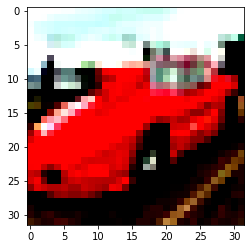

In [29]:
# por ultimo podemos hacer un test unico, para una imagen del dataset
img, label = validation_set[20]
# obtenemos la prediccion
out = model(img.view(-1).unsqueeze(0))
# y sacamos el mazimo de probabilidad
# para poder calcular este valor.
_, index = torch.max(out, dim=1)

# mostramos lo que se supone debe ser y lo que devolvio el modelo
print('->: ',class_names[label],' model:',class_names[index])
# mostramos la imagen
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Mejoras, limitaciones y conclusiones
---


In [30]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.442056
Epoch: 1, Loss: 0.573583
Epoch: 2, Loss: 0.591843
Epoch: 3, Loss: 0.542523
Epoch: 4, Loss: 0.792305
Epoch: 5, Loss: 0.512888
Epoch: 6, Loss: 0.319859
Epoch: 7, Loss: 0.266392
Epoch: 8, Loss: 0.379794
Epoch: 9, Loss: 0.204519
Epoch: 10, Loss: 0.387621
Epoch: 11, Loss: 0.385690
Epoch: 12, Loss: 0.395168
Epoch: 13, Loss: 0.136324
Epoch: 14, Loss: 0.079962
Epoch: 15, Loss: 0.102180
Epoch: 16, Loss: 0.399909
Epoch: 17, Loss: 0.093124
Epoch: 18, Loss: 0.140991
Epoch: 19, Loss: 0.382630
Epoch: 20, Loss: 0.076995
Epoch: 21, Loss: 0.263533
Epoch: 22, Loss: 0.256963
Epoch: 23, Loss: 0.099594
Epoch: 24, Loss: 0.224731
Epoch: 25, Loss: 0.031625
Epoch: 26, Loss: 0.184188
Epoch: 27, Loss: 0.083556
Epoch: 28, Loss: 0.067148
Epoch: 29, Loss: 0.065209
Epoch: 30, Loss: 0.129370
Epoch: 31, Loss: 0.117633
Epoch: 32, Loss: 0.011387
Epoch: 33, Loss: 0.038123
Epoch: 34, Loss: 0.042403
Epoch: 35, Loss: 0.006221
Epoch: 36, Loss: 0.013009
Epoch: 37, Loss: 0.011647
Epoch: 38, Loss: 0.006

In [31]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.866500


In [32]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct:  car  model: cat


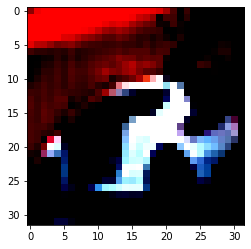

In [33]:
img, label = validation_set[1]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print('correct: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))

In [34]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [35]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [36]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [37]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: car   model: cat


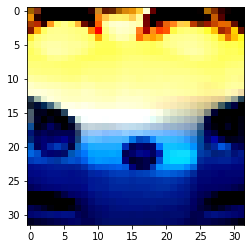

In [38]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
                            
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))